In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import shapiro

from eff.analysis import mann_whitney_test, wilcoxon_signed_rank_test
from eff.analysis.plotting import set_lang_ax
from eff.util.util import load_results

In [2]:
base_path = Path("./out/nelex_unique")
dataset, res, criterion, model = load_results(base_path, 'tur')
fontsize=18

In [3]:
# harmonic groups
front_vowels = ['œ', 'i', 'ɛ', 'y']
back_vowels = ['o', 'u', 'a', 'ɯ']
rounded_vowels = ['o', 'œ', 'y', 'u']
unrounded_vowels = ['i', 'ɛ', 'a', 'ɯ']

In [4]:
# model probe front harmony (feature surprisal)
clts_ds = dataset['clts']
bipa = clts_ds.bipa
output_alphabet = clts_ds.output_alphabet
logprobs = res['unmasked']['logprobs']
targets = res['unmasked']['targets']
target_indices = res['unmasked']['indices']

front_indices = [output_alphabet.char2idx(v) for v in front_vowels]
back_indices = [output_alphabet.char2idx(v) for v in back_vowels]

ff_surprisal = []
bb_surprisal = []
fb_surprisal = []
bf_surprisal = []


for indices_word, targets_word, logprobs_word in zip(target_indices, targets, logprobs):
    vowel_indices = [targets_word[idx] for idx in indices_word]
    if len(vowel_indices) >= 2:
        for i in range(len(vowel_indices)-1, 0, -1):
            idx = vowel_indices[i]
            prev_idx = vowel_indices[i-1]
            target_idx = indices_word[i] # first index of the logprobs
            # need char to determine harmonic group
            vowel = output_alphabet.idx2char(idx)
            prev_vowel = output_alphabet.idx2char(prev_idx)

            if not clts_ds.bipa[vowel].type == 'diphthong' \
            and not clts_ds.bipa[vowel].type == 'diphthong':

                if prev_vowel in front_vowels:
                    target_logprobs = logprobs_word[target_idx]
                    harmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in front_indices])
                    disharmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in back_indices])
                    harmonic_surprisal = -np.log2(harmonic_surprisal)
                    disharmonic_surprisal = -np.log2(disharmonic_surprisal)
                    ff_surprisal.append(harmonic_surprisal)
                    fb_surprisal.append(disharmonic_surprisal)
                elif prev_vowel in back_vowels:
                    target_logprobs = logprobs_word[target_idx]
                    harmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in back_indices])
                    disharmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in front_indices])
                    harmonic_surprisal = -np.log2(harmonic_surprisal)
                    disharmonic_surprisal = -np.log2(disharmonic_surprisal)
                    bb_surprisal.append(harmonic_surprisal)
                    bf_surprisal.append(disharmonic_surprisal)


n_ff = len(ff_surprisal)
n_fb = len(fb_surprisal)
n_bb = len(bb_surprisal)
n_bf = len(bf_surprisal)

front_harmonic_surprisal = ff_surprisal + bb_surprisal
front_disharmonic_surprisal = fb_surprisal + bf_surprisal

delta_mean_f = np.mean(ff_surprisal) - np.mean(fb_surprisal)
delta_mean_b = np.mean(bb_surprisal) - np.mean(bf_surprisal)
delta_mean_disharmonic = np.mean(fb_surprisal) - np.mean(bf_surprisal)
print(delta_mean_f)
print(delta_mean_b)
print(delta_mean_disharmonic)

-3.1501749663321577
-4.072919907147765
-0.8602017606151144


In [5]:
print(shapiro(front_harmonic_surprisal))
print(shapiro(front_disharmonic_surprisal))

print(shapiro(ff_surprisal))
print(shapiro(fb_surprisal))
print(shapiro(bb_surprisal))
print(shapiro(bf_surprisal))

ShapiroResult(statistic=0.46787750720977783, pvalue=3.7130978316121894e-34)
ShapiroResult(statistic=0.9726504683494568, pvalue=2.396661784587195e-07)
ShapiroResult(statistic=0.4243393540382385, pvalue=3.5000046536491964e-24)
ShapiroResult(statistic=0.8933473229408264, pvalue=2.6346300141533163e-10)
ShapiroResult(statistic=0.5228880643844604, pvalue=1.0211265773999152e-25)
ShapiroResult(statistic=0.9622750282287598, pvalue=3.237613100282033e-06)


In [6]:
# significance test +-BACK harmony
U, p_value, r = wilcoxon_signed_rank_test(ff_surprisal, fb_surprisal)
print("f\_f/f\_b & {} &  {} & {} & {} & Wilcoxon \\\\".format(round(delta_mean_f, 4), U, p_value, round(r, 4)))
U, p_value, r = wilcoxon_signed_rank_test(bb_surprisal, bf_surprisal)
print("b\_b/b\_f & {} & {} & {} & {} & Wilcoxon \\\\".format(round(delta_mean_b, 4), U, p_value, round(r, 4)))
U, p_value, r = mann_whitney_test(fb_surprisal, bf_surprisal)
print("f\_b/b\_f & {} & {} & {} & {} & Mann-Whitney \\\\".format(round(delta_mean_disharmonic, 4), U, p_value, round(r, 4)))

f\_f/f\_b & -3.1502 &  429.0 & 1.653436986585943e-29 & 0.0244 & Wilcoxon \\
b\_b/b\_f & -4.0729 & 258.0 & 4.251651709333522e-42 & 0.008 & Wilcoxon \\
f\_b/b\_f & -0.8602 & 14301.0 & 9.154890389761678e-13 & -0.3978 & Mann-Whitney \\


In [7]:
# model probe roundedness harmony (feature surprisal)
rr_surprisal = []
uu_surprisal = []
ur_surprisal = []
ru_surprisal = []

rounded_indices = [output_alphabet.char2idx(v) for v in rounded_vowels]
unrounded_indices = [output_alphabet.char2idx(v) for v in unrounded_vowels]


for indices_word, targets_word, logprobs_word in zip(target_indices, targets, logprobs):
    vowel_indices = [targets_word[idx] for idx in indices_word]
    if len(vowel_indices) >= 2:
        for i in range(len(vowel_indices)-1, 0, -1):
            idx = vowel_indices[i]
            prev_idx = vowel_indices[i-1]
            target_idx = indices_word[i] # first index of the logprobs
            # need char to determine harmonic group
            vowel = output_alphabet.idx2char(idx)
            prev_vowel = output_alphabet.idx2char(prev_idx)

            if not clts_ds.bipa[vowel].type == 'diphthong' \
            and not clts_ds.bipa[vowel].type == 'diphthong':

                if prev_vowel in rounded_vowels:
                    target_logprobs = logprobs_word[target_idx]
                    harmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in rounded_indices])
                    disharmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in unrounded_indices])
                    harmonic_surprisal = -np.log2(harmonic_surprisal)
                    disharmonic_surprisal = -np.log2(disharmonic_surprisal)
                    rr_surprisal.append(harmonic_surprisal)
                    ru_surprisal.append(disharmonic_surprisal)
                elif prev_vowel in unrounded_vowels:
                    target_logprobs = logprobs_word[target_idx]
                    harmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in unrounded_indices])
                    disharmonic_surprisal = sum([2**(-l) for i, l in enumerate(target_logprobs) if i in rounded_indices])
                    harmonic_surprisal = -np.log2(harmonic_surprisal)
                    disharmonic_surprisal = -np.log2(disharmonic_surprisal)
                    uu_surprisal.append(harmonic_surprisal)
                    ur_surprisal.append(disharmonic_surprisal)


n_rr = len(rr_surprisal)
n_ru = len(ru_surprisal)
n_uu = len(uu_surprisal)
n_ur = len(ur_surprisal)

rounded_harmonic_surprisal = rr_surprisal + uu_surprisal
rounded_disharmonic_surprisal = ru_surprisal + ur_surprisal

delta_mean_r = np.mean(rr_surprisal) - np.mean(ru_surprisal)
delta_mean_u = np.mean(uu_surprisal) - np.mean(ur_surprisal)
delta_mean_disharmonic = np.mean(ru_surprisal) - np.mean(ur_surprisal)
print(delta_mean_r)
print(delta_mean_f)
print(delta_mean_disharmonic)

-1.0515745393766907
-3.1501749663321577
-1.582655192467608


In [8]:
print(shapiro(rounded_harmonic_surprisal))
print(shapiro(rounded_disharmonic_surprisal))

print(shapiro(rr_surprisal))
print(shapiro(ru_surprisal))
print(shapiro(uu_surprisal))
print(shapiro(ru_surprisal))

ShapiroResult(statistic=0.5292544364929199, pvalue=1.2723186450051685e-32)
ShapiroResult(statistic=0.987420380115509, pvalue=0.000741108669899404)
ShapiroResult(statistic=0.6642023324966431, pvalue=1.00964538379128e-13)
ShapiroResult(statistic=0.9698960781097412, pvalue=0.022746438160538673)
ShapiroResult(statistic=0.7229400277137756, pvalue=1.930881900390625e-23)
ShapiroResult(statistic=0.9698960781097412, pvalue=0.022746438160538673)


In [9]:
# significance tests +-ROUND harmony
U, p_value, r = wilcoxon_signed_rank_test(rr_surprisal, ru_surprisal)
print("r\_r/r\_u & {} &  {} & {} & {} & Wilcoxon \\\\".format(round(delta_mean_r, 4), U, p_value, round(r, 4)))
U, p_value, r = wilcoxon_signed_rank_test(uu_surprisal, ur_surprisal)
print("u\_u/u\_r & {} & {} & {} & {} & Wilcoxon \\\\".format(round(delta_mean_u, 4), U, p_value, round(r, 4)))
U, p_value, r = mann_whitney_test(ru_surprisal, ur_surprisal)
print("r\_u/u\_r & {} & {} & {} & {} & Mann-Whitney \\\\".format(round(delta_mean_disharmonic, 4), U, p_value, round(r, 4)))

r\_r/r\_u & -1.0516 &  1107.0 & 1.799281583001314e-06 & 0.2236 & Wilcoxon \\
u\_u/u\_r & -3.185 & 10.0 & 8.99382921698032e-58 & 0.0002 & Wilcoxon \\
r\_u/u\_r & -1.5827 & 6339.0 & 2.4815610840567342e-21 & -0.6256 & Mann-Whitney \\


In [10]:
# significance tests +-BACK vs +-ROUND harmony
delta_mean_front = np.mean(front_harmonic_surprisal) - np.mean(front_disharmonic_surprisal)
delta_mean_rounded = np.mean(rounded_harmonic_surprisal) - np.mean(rounded_disharmonic_surprisal)
delta_mean_disharmonic = np.mean(front_disharmonic_surprisal) - np.mean(rounded_disharmonic_surprisal)
U, p_value, r = wilcoxon_signed_rank_test(front_harmonic_surprisal, front_disharmonic_surprisal)
print("f\_h/dish & {} &  {} & {} & {} & Wilcoxon \\\\".format(round(delta_mean_front, 4), U, p_value, round(r, 4)))
U, p_value, r = wilcoxon_signed_rank_test(rounded_harmonic_surprisal, rounded_disharmonic_surprisal)
print("r\_h/dish & {} & {} & {} & {} & Wilcoxon \\\\".format(round(delta_mean_rounded, 4), U, p_value, round(r, 4)))
U, p_value, r = mann_whitney_test(front_disharmonic_surprisal, rounded_disharmonic_surprisal)
print("f/r\_dish & {} & {} & {} & {} & Mann-Whitney\\\\".format(round(delta_mean_disharmonic, 4), U, p_value, round(r, 4)))

f\_h/dish & -3.6816 &  1348.0 & 4.708631933674632e-70 & 0.0138 & Wilcoxon \\
r\_h/dish & -2.7061 & 3473.0 & 4.5024920680920086e-64 & 0.0356 & Wilcoxon \\
f/r\_dish & 0.8555 & 132794.0 & 5.546560949580453e-21 & 0.3656 & Mann-Whitney\\


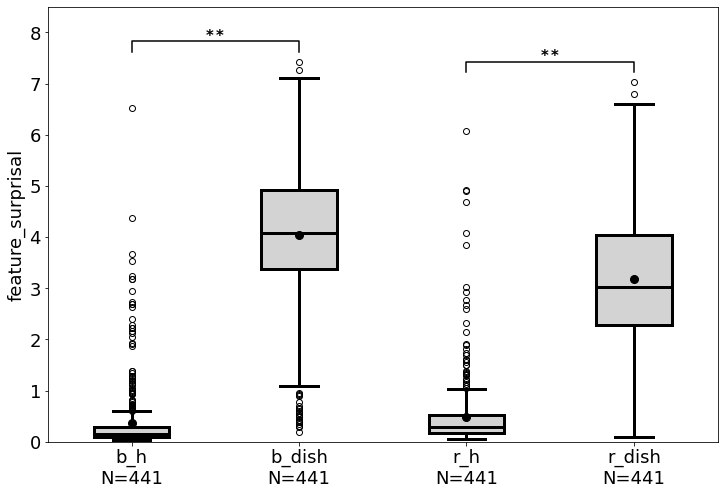

In [11]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 1, hspace=0.15, wspace=0.25)
ax = gs.subplots()

ax.set_ylim([0,8.5])


data = [
    front_harmonic_surprisal,
    front_disharmonic_surprisal,
    rounded_harmonic_surprisal,
    rounded_disharmonic_surprisal
]
xlabels = [
    "b_h\nN={}".format(len(front_harmonic_surprisal)),
    "b_dish\nN={}".format(len(front_disharmonic_surprisal)),
    "r_h\nN={}".format(len(rounded_harmonic_surprisal)),
    "r_dish\nN={}".format(len(rounded_disharmonic_surprisal))
]

set_lang_ax(ax, data, xlabels, 
    title=None,
    boxcolor='lightgrey',
    fontsize=fontsize,
    ylabel="feature_surprisal"
)

# significance front harmonic/disharmonic
x1, x2 = 1, 2
y, h, col = max(front_disharmonic_surprisal) + 0.2, 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, r"$\bf{**}$", ha='center', va='bottom', color=col, fontsize=15)

# significance rounded harmonic/disharmonic
x1, x2 = 3, 4
y, h, col = max(rounded_disharmonic_surprisal) + 0.2, 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, r"$\bf{**}$", ha='center', va='bottom', color=col, fontsize=15)

plt.savefig("../img/surprisal_harmonic_disharmonic2_tur.png",
        bbox_inches='tight',
        pad_inches=0,
        format='png',
        dpi=300)

In [12]:
res = mann_whitney_test(ff_surprisal, fb_surprisal)
print(res)
res = mann_whitney_test(bb_surprisal, bf_surprisal)
print(res)

(826.0, 3.6125133562663957e-57, -0.9527581572249706)
(733.0, 5.7846625593841425e-81, -0.9772769545539091)


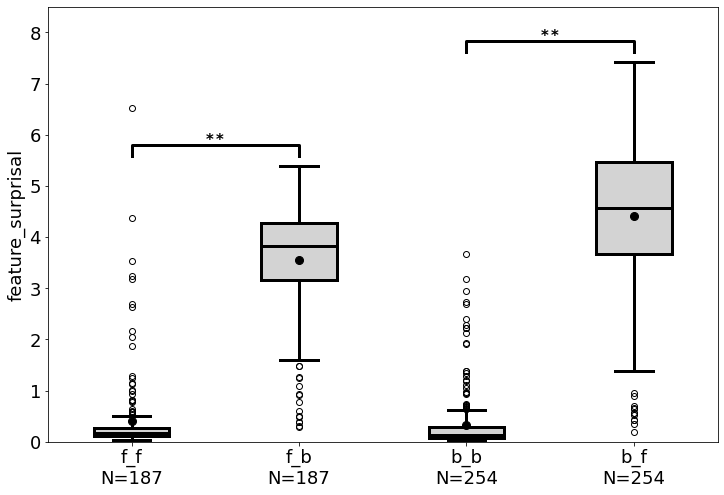

In [13]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 1, hspace=0.15, wspace=0.25)
ax = gs.subplots()

ax.set_ylim([0,8.5])

data = [
    ff_surprisal, 
    fb_surprisal, 
    bb_surprisal,
    bf_surprisal 
]
xlabels = [
    "f_f\nN={}".format(n_ff),
    "f_b\nN={}".format(n_fb),
    "b_b\nN={}".format(n_bb),
    "b_f\nN={}".format(n_bf)
    # "Neutral Harmonic\nN={}".format(n_nf),
    # "Neutral Disharmonic\nN={}".format(n_nb)
]

set_lang_ax(ax, data, xlabels, 
    # title='Turkish',
    title=None,
    boxcolor='lightgrey',
    fontsize=fontsize,
    ylabel="feature_surprisal"
)

# significance front/back violation
x1, x2 = 1, 2
y, h, col = max(fb_surprisal) + 0.2, 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
plt.text((x1+x2)*.5, y+h, r"$\bf{**}$", ha='center', va='bottom', color=col, fontsize=15)

# significance rounded/unrounded violation
x1, x2 = 3, 4
y, h, col = max(bf_surprisal) + 0.2, 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
plt.text((x1+x2)*.5, y+h, r"$\bf{**}$", ha='center', va='bottom', color=col, fontsize=15)

plt.savefig("../img/surprisal_front2_harmony_tur.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)

In [14]:
res = mann_whitney_test(rr_surprisal, ru_surprisal)
print(res)
res = mann_whitney_test(uu_surprisal, ur_surprisal)
print(res)

(2131.0, 6.492867037004428e-12, -0.5651464136312621)
(319.0, 3.363252122419052e-112, -0.9945453301870661)


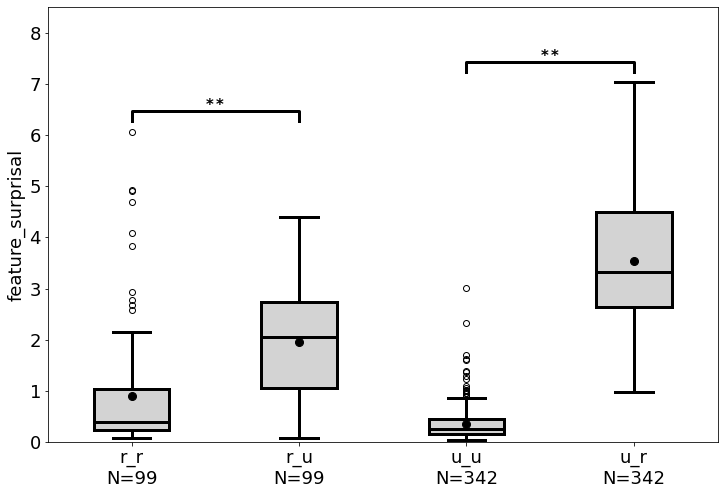

In [15]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 1, hspace=0.15, wspace=0.25)
ax = gs.subplots()

ax.set_ylim([0,8.5])

data = [
    rr_surprisal,
    ru_surprisal, 
    uu_surprisal,
    ur_surprisal
]
xlabels = [
    "r_r\nN={}".format(n_rr),
    "r_u\nN={}".format(n_ru),
    "u_u\nN={}".format(n_uu),
    "u_r\nN={}".format(n_ur)
]

set_lang_ax(ax, data, xlabels, 
    # title='Turkish',
    title=None,
    boxcolor='lightgrey',
    fontsize=fontsize,
    ylabel="feature_surprisal"
)

# significance rounded/unrounded violation
x1, x2 = 1, 2
y, h, col = max(rr_surprisal) + 0.2, 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
plt.text((x1+x2)*.5, y+h, r"$\bf{**}$", ha='center', va='bottom', color=col, fontsize=15)

# significance rounded/unrounded violation
x1, x2 = 3, 4
y, h, col = max(ur_surprisal) + 0.2, 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
plt.text((x1+x2)*.5, y+h, r"$\bf{**}$", ha='center', va='bottom', color=col, fontsize=15)

plt.savefig("../img/surprisal_rounded2_harmony_tur.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)